# Advanced Lane Line Finding Project Workbook

## Libraries and Includes

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

## Camera Calibration

In [2]:
# Update the number of x points to 9 as indicated in the lesson
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
numberOfUndetected = 0
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), flags=(cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK))

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found_'+ fname.split('\\')[-1]
        #print(write_name)
        cv2.imwrite(write_name, image)
    else:
        numberOfUndetected = numberOfUndetected + 1

print(numberOfUndetected)

3


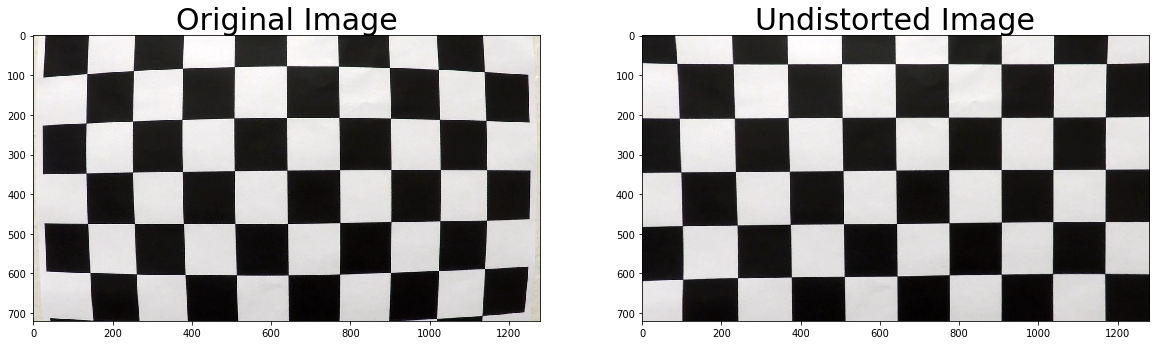

In [3]:
# Test undistortion on an image
image = plt.imread('camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (image.shape[1], image.shape[0]),None,None)

dst = cv2.undistort(image, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply Distortion Correction to Test Images

In [4]:
# Load pickled data
calibration_data = "camera_cal/dist_pickle.p"

with open(calibration_data, mode='rb') as f:
    dist_pickle = pickle.load(f)
    
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [5]:
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

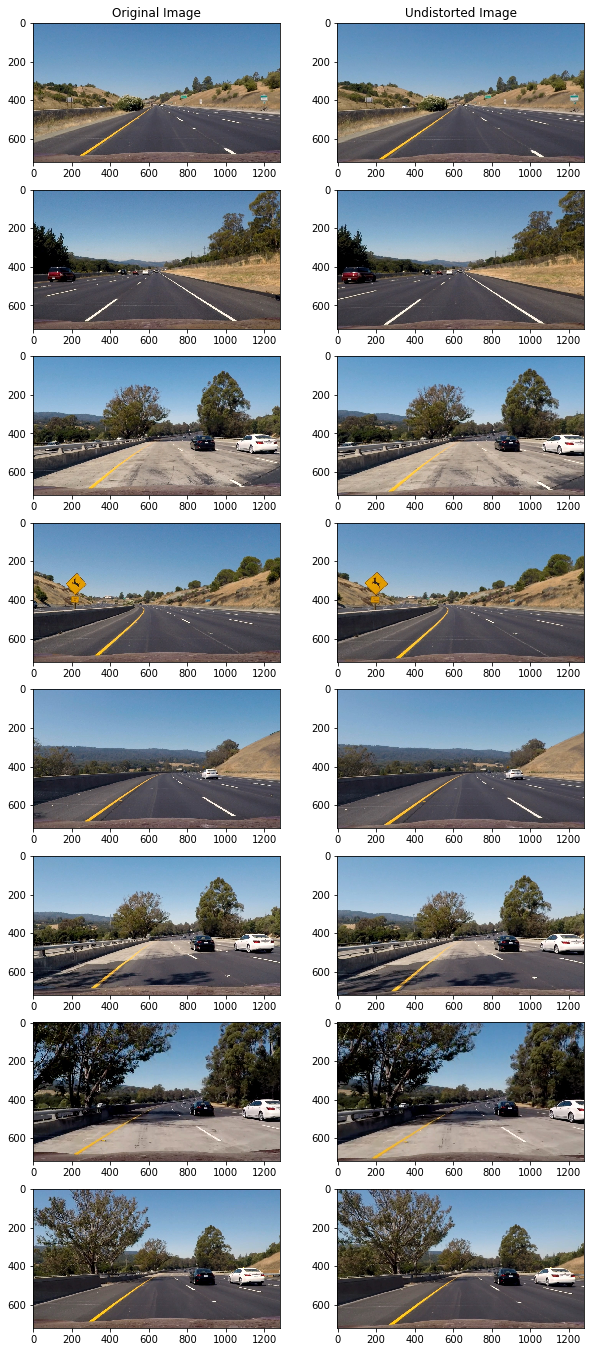

In [6]:
images_name = glob.glob('test_images/*')

plt.figure(figsize=(10, 24))

images = []
for idx, fname in enumerate(images_name):
    image = plt.imread(fname)
    plt.subplot(len(images_name), 2, idx*2+1)
    plt.imshow(image)
    if (idx == 0):
        plt.title("Original Image")
    
    image = undistort(image)
    plt.subplot(len(images_name), 2, idx*2+2)
    images.append(image)
    plt.imshow(image)
    if (idx == 0):
        plt.title("Undistorted Image")

## Create Thresholded Binary Test Images

### Visualise in RGB Space

Blue channel does not pick up yellow lines, wheras green and red do. Only perform thresholding on these two channels.

Red channels consistantly picks up the lane lines better than the other two channels.

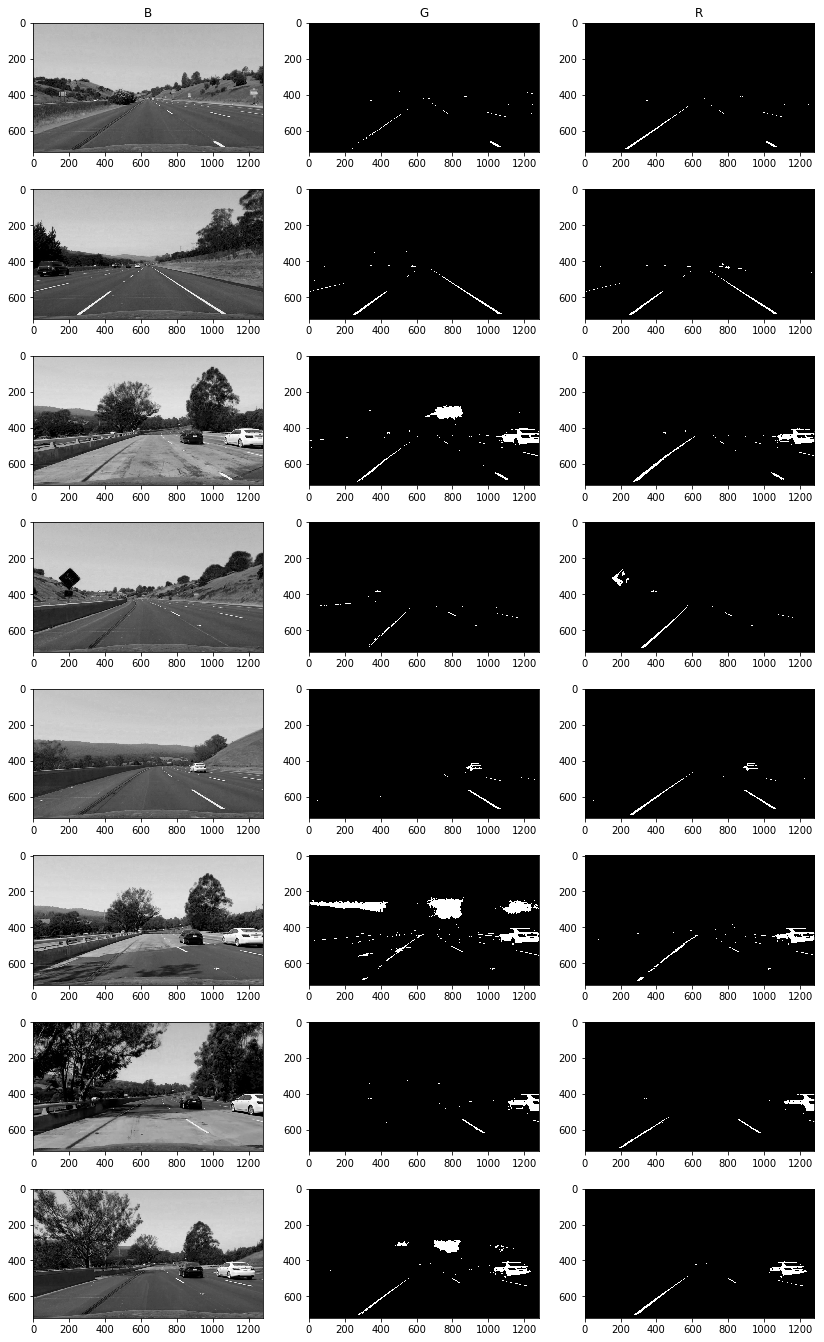

In [7]:
plt.figure(figsize=(14, 24))

G_threshold = (200, 255)
R_threshold = (225, 255)

for idx, image in enumerate(images):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    
    plt.subplot(len(images), 3, idx*3+1)
    plt.imshow(B, cmap='gray')
    if (idx == 0):
        plt.title("B")
        
    plt.subplot(len(images), 3, idx*3+2)
    G_binary = np.zeros_like(G)
    G_binary[(G > G_threshold[0]) & (G <= G_threshold[1])] = 1
    plt.imshow(G_binary, cmap='gray')
    if (idx == 0):
        plt.title("G")
        
    plt.subplot(len(images), 3, idx*3+3)
    R_binary = np.zeros_like(G)
    R_binary[(R > R_threshold[0]) & (R <= R_threshold[1])] = 1
    plt.imshow(R_binary, cmap='gray')
    if (idx == 0):
        plt.title("R")
        
    # breaking early to reduce page size
    #break

Red channel seems to give good results

### Visualise in LAB Space

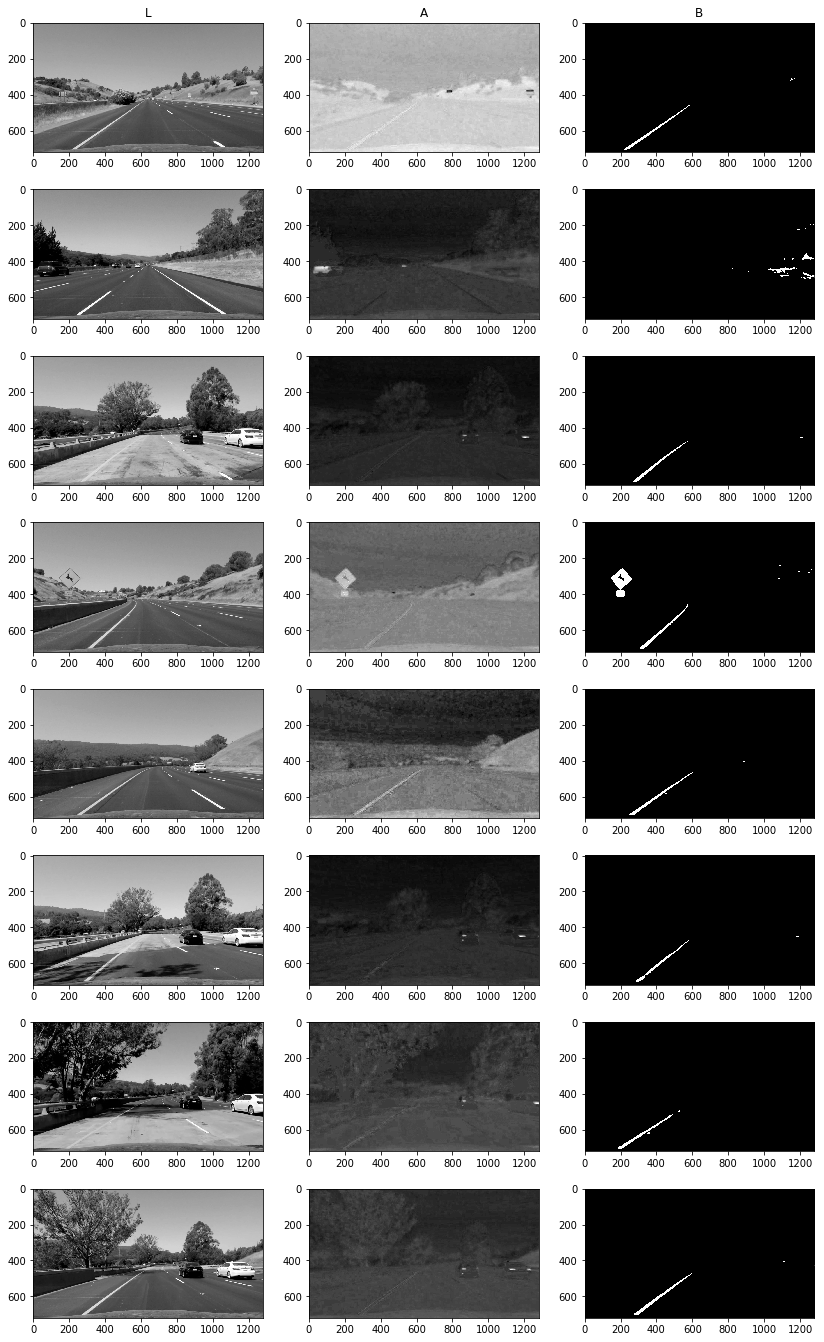

In [8]:
plt.figure(figsize=(14, 24))

for idx, image in enumerate(images):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]
    
    plt.subplot(len(images), 3, idx*3+1)
    plt.imshow(L, cmap='gray')
    if (idx == 0):
        plt.title("L")
    
    plt.subplot(len(images), 3, idx*3+2)
    plt.imshow(A, cmap='gray')
    if (idx == 0):
        plt.title("A")
    
    plt.subplot(len(images), 3, idx*3+3)
    
    B_threshold = (160, 255)
    B_binary = np.zeros_like(B)
    B_binary[(B > B_threshold[0]) & (B <= B_threshold[1])] = 1
    
    plt.imshow(B_binary, cmap='gray')
    if (idx == 0):
        plt.title("B")
    
    # breaking early to reduce page size
    #break

The B colour space is suprisingly good at picking out yellow lane lines. Therefore I will combine the results of the red channel and B channel to enhance the yellow lane detection.

In [9]:
def edge_detection(image):
    R = image[:,:,0]
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    _, R_binary = cv2.threshold(R.astype('uint8'), 225, 255, cv2.THRESH_BINARY)
    
    B = lab[:,:,2]
    _, B_binary = cv2.threshold(B.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    
    combined_binary = np.clip(cv2.bitwise_or(R_binary, B_binary), 0, 1).astype('uint8')
    
    return combined_binary

921600


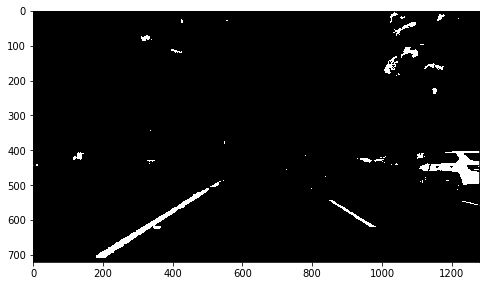

In [10]:
plt.figure(figsize=(8, 24))

for idx, image in enumerate(images):
    edge_detected = edge_detection(image)
    
    if (idx == 6):
        print(edge_detected.size)
        plt.imshow(edge_detected, cmap='gray')

## Apply a perspective transform to rectify binary image

Using the two straight lane images to develop the perspective transform

In [11]:
def perspective_transform(image, topdown):
    src = np.float32([[190,720],[584,457],[705,457],[1145,720]])
    new_top_left = np.array([src[0,0],0])
    new_top_right = np.array([src[3,0],0])
    offset  =[150,0]

    dst = np.float32([src[0]+offset,new_top_left+offset,new_top_right-offset ,src[3]-offset])    
    
    if topdown:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
        
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)    
    
    return warped, M

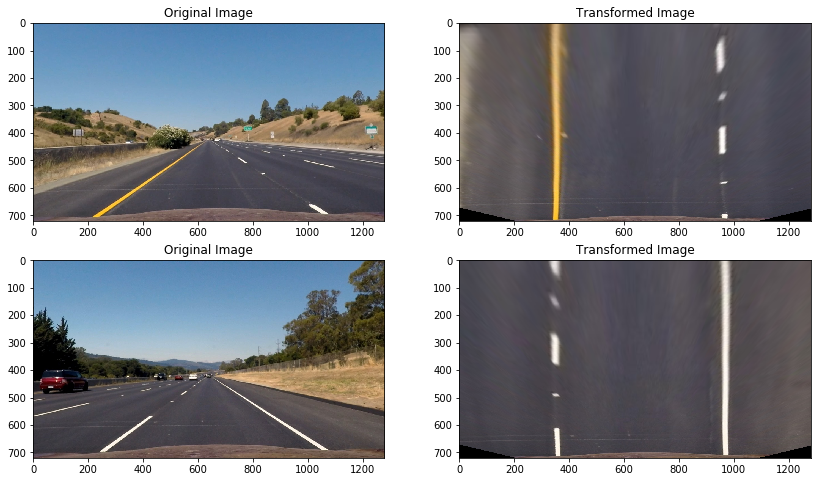

In [12]:
straight_images_name = glob.glob('test_images/straight_lines*')
plt.figure(figsize=(14, 8))

for idx, fname in enumerate(straight_images_name):
    image = plt.imread(fname)
    image = undistort(image)
    
    plt.subplot(len(straight_images_name), 2, idx*2+1)
    plt.imshow(image)
    plt.title("Original Image")
    
    transformed, M = perspective_transform(image, True)
    plt.subplot(len(straight_images_name), 2, idx*2+2)
    plt.imshow(transformed)
    plt.title("Transformed Image")

Apply to binary image

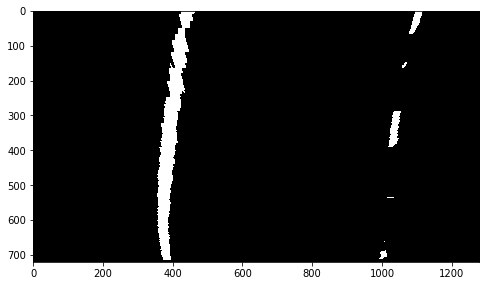

In [13]:
plt.figure(figsize=(8, 24))

for idx, image in enumerate(images):
    edge_detected = edge_detection(image)
    
    transformed, _ = perspective_transform(edge_detected, True)
    
    if (idx == 2):
        plt.imshow(transformed, cmap='gray')


## Locate the Lane Lines and Fit a Polynomial

In [14]:
def line_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    min_inds = 1
    if left_lane_inds.size == 0 or right_lane_inds.size == 0:
        return None

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Return a dict of relevant variables
    ret = {}
    ret['left_fit'] = left_fit
    ret['right_fit'] = right_fit
    ret['nonzerox'] = nonzerox
    ret['nonzeroy'] = nonzeroy
    ret['out_img'] = out_img
    ret['left_lane_inds'] = left_lane_inds
    ret['right_lane_inds'] = right_lane_inds

    return ret

[ -1.31501734e-05   1.19741432e-02   3.51908093e+02]
[  2.64499439e-05  -1.77807620e-03   3.46977763e+02]
[  1.55886175e-04  -2.05743781e-01   4.42361535e+02]
[ -2.81249339e-04   3.86513781e-01   2.74566950e+02]
[  1.23978910e-04  -2.98858393e-01   5.19723918e+02]
[  1.86568949e-04  -2.04314698e-01   4.48680758e+02]
[  3.18784945e-04  -4.08873116e-01   4.57760355e+02]
[  1.50431712e-04  -3.34657452e-01   5.46974737e+02]


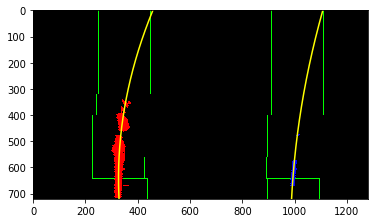

In [15]:
for idx, image in enumerate(images):
    edge_detected = edge_detection(image)

    transformed, _ = perspective_transform(edge_detected, True)

    fit_result = line_fit(transformed)

    left_fit = fit_result['left_fit']
    right_fit = fit_result['right_fit']
    nonzerox = fit_result['nonzerox']
    nonzeroy = fit_result['nonzeroy']
    left_lane_inds = fit_result['left_lane_inds']
    right_lane_inds = fit_result['right_lane_inds']
    out_img = fit_result['out_img']
    print(left_fit)

    if (idx == 6):
        # Generate x and y values for plotting
        ploty = np.linspace(0, transformed.shape[0]-1, transformed.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

## Measuring Curvature

In [16]:
def calc_curve(fit_result):
    nonzerox = fit_result['nonzerox']
    nonzeroy = fit_result['nonzeroy']
    left_lane_inds = fit_result['left_lane_inds']
    right_lane_inds = fit_result['right_lane_inds']

    y_eval = 719

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

In [17]:
def calc_vehicle_offset(image_shape, left_fit, right_fit):
    """
    Calculate vehicle offset from lane center, in meters
    """
    # Calculate vehicle center offset in pixels
    bottom_y = image_shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    vehicle_offset = image_shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    # Convert pixel offset to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix

    return vehicle_offset

In [18]:
for idx, image in enumerate(images):
    edge_detected = edge_detection(image)

    transformed, _ = perspective_transform(edge_detected, True)

    fit_result = line_fit(transformed)

    left_curverad, right_curverad = calc_curve(fit_result)
    
    vehicle_offset = calc_vehicle_offset(image.shape, fit_result['left_fit'], fit_result['right_fit'])

    print(left_curverad, 'm', right_curverad, 'm', vehicle_offset*100, 'cm')

12488.5743119 m 23826.5757075 m -10.6740251136 cm
6209.16016427 m 27221.9825694 m -12.3547174833 cm
1053.51274095 m 958.084923309 m -26.1561370963 cm
583.923150611 m 1532.15562317 m -45.1992207604 cm
1325.09929451 m 762.520143486 m -21.8799819744 cm
880.333793642 m 756.793924818 m -37.3595319153 cm
515.195144726 m 1032.44732681 m -9.77277550537 cm
1092.07188818 m 724.303207815 m -35.1354886011 cm


## Define a class to receive the characteristics of each line detection

In [19]:
class Line():
    def __init__(self, n):
        """
        n is the window size of the moving average
        """
        self.n = n
        self.detected = False

        # Polynomial coefficients: x = A*y^2 + B*y + C
        # Each of A, B, C is a "list-queue" with max length n
        self.A = []
        self.B = []
        self.C = []
        # Average of above
        self.A_avg = 0.
        self.B_avg = 0.
        self.C_avg = 0.

    def get_fit(self):
        return (self.A_avg, self.B_avg, self.C_avg)

    def add_fit(self, fit_coeffs):
        """
        Gets most recent line fit coefficients and updates internal smoothed coefficients
        fit_coeffs is a 3-element list of 2nd-order polynomial coefficients
        """
        # Coefficient queue full?
        q_full = len(self.A) >= self.n

        # Append line fit coefficients
        self.A.append(fit_coeffs[0])
        self.B.append(fit_coeffs[1])
        self.C.append(fit_coeffs[2])

        # Pop from index 0 if full
        if q_full:
            _ = self.A.pop(0)
            _ = self.B.pop(0)
            _ = self.C.pop(0)

        # Simple average of line coefficients
        self.A_avg = np.mean(self.A)
        self.B_avg = np.mean(self.B)
        self.C_avg = np.mean(self.C)

        return (self.A_avg, self.B_avg, self.C_avg)

## Build the processing pipeline

In [20]:
def process_image(image):
    undist = undistort(image)
    edge_detected = edge_detection(undist)
    transformed, _ = perspective_transform(edge_detected, True)

    fit_result = line_fit(transformed)

    left_curverad, right_curverad = calc_curve(fit_result)
    
    vehicle_offset = calc_vehicle_offset(image.shape, fit_result['left_fit'], fit_result['right_fit'])
    
    left_fit = fit_result['left_fit']
    right_fit = fit_result['right_fit']
    nonzerox = fit_result['nonzerox']
    nonzeroy = fit_result['nonzeroy']
    left_lane_inds = fit_result['left_lane_inds']
    right_lane_inds = fit_result['right_lane_inds']
    
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(transformed).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp, _ = perspective_transform(color_warp, False)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Annotate lane curvature values and vehicle offset from center
    avg_curverad = (left_curverad + right_curverad)/2
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = 'Radius of curvature: %.1f m' % avg_curverad
    cv2.putText(result,str1,(450,630), font, 1,(0,0,255),2,cv2.LINE_AA)

    str2 = 'Vehicle offset from center: %.1f cm' % (vehicle_offset*100)
    cv2.putText(result,str2,(400,670), font, 1,(0,0,255),2,cv2.LINE_AA)  
    
    return result

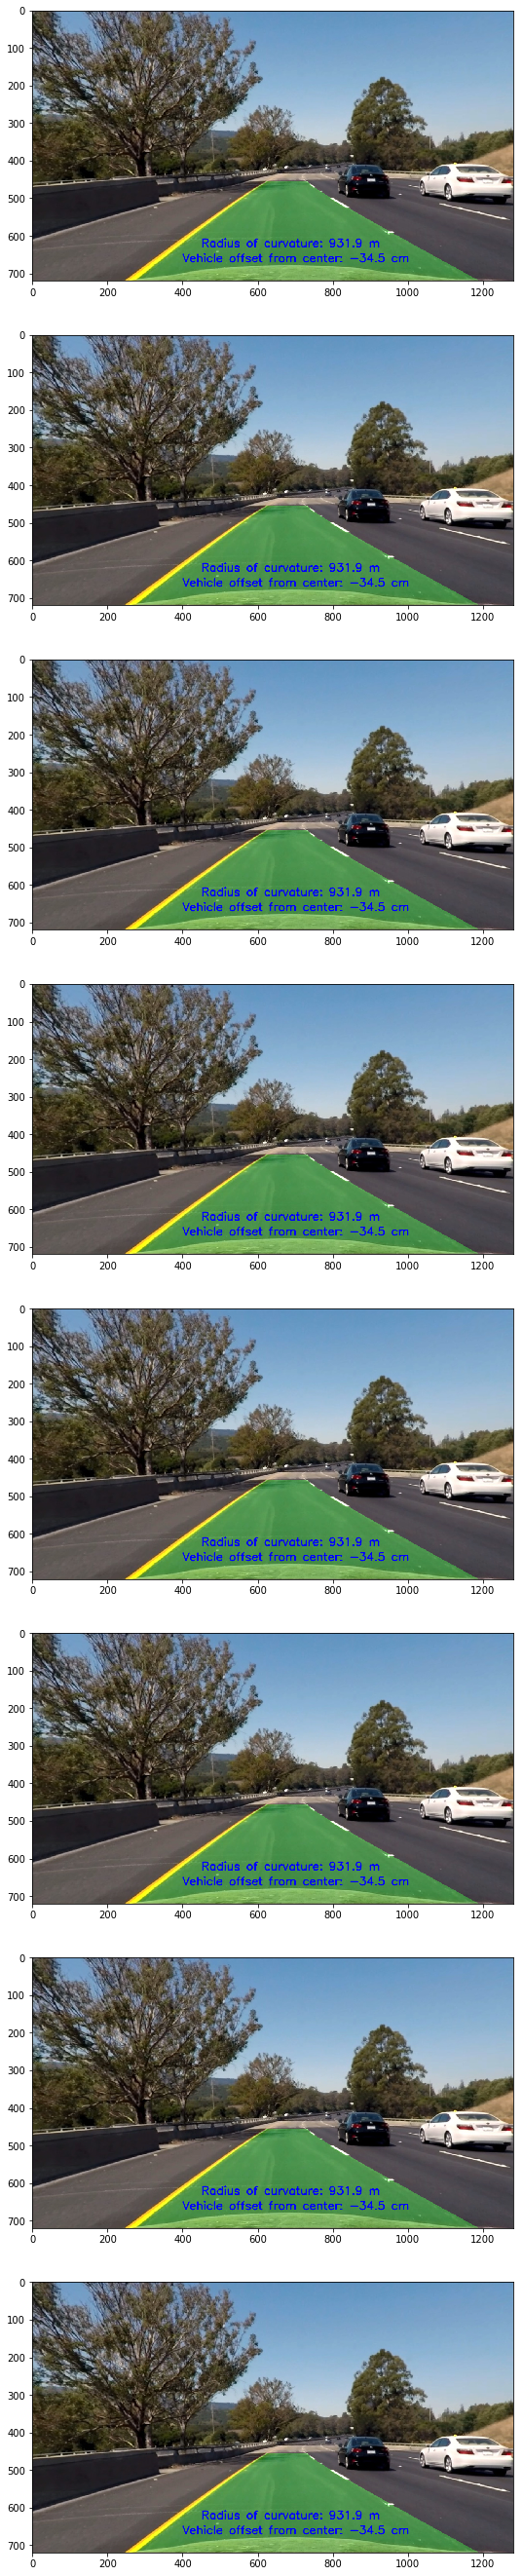

In [21]:
images_name = glob.glob('test_images/*')

plt.figure(figsize=(15, 48))

for idx, fname in enumerate(images_name):
    processed = process_image(image)
    plt.subplot(len(images_name), 1, idx+1)
    plt.imshow(processed)

## Processing Videos

In [22]:
left_line = Line(10)
right_line = Line(10)

In [23]:
def process_video(image):
    undist = undistort(image)
    edge_detected = edge_detection(undist)
    transformed, _ = perspective_transform(edge_detected, True)

    fit_result = line_fit(transformed)
    
    if fit_result is None:
        result = undist
    else:
        left_curverad, right_curverad = calc_curve(fit_result)
        
        vehicle_offset = calc_vehicle_offset(image.shape, fit_result['left_fit'], fit_result['right_fit'])

        left_fit = fit_result['left_fit']
        right_fit = fit_result['right_fit']
        nonzerox = fit_result['nonzerox']
        nonzeroy = fit_result['nonzeroy']
        left_lane_inds = fit_result['left_lane_inds']
        right_lane_inds = fit_result['right_lane_inds']
        
        ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(transformed).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp, _ = perspective_transform(color_warp, False)
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        # Annotate lane curvature values and vehicle offset from center
        avg_curverad = (left_curverad + right_curverad)/2
        font = cv2.FONT_HERSHEY_SIMPLEX
        str1 = 'Radius of curvature: %.1f m' % avg_curverad
        cv2.putText(result,str1,(450,630), font, 1,(0,0,255),2,cv2.LINE_AA)

        str2 = 'Vehicle offset from center: %.1f cm' % (vehicle_offset*100)
        cv2.putText(result,str2,(400,670), font, 1,(0,0,255),2,cv2.LINE_AA)
        
    return result
    #return 255*np.dstack((edge_detected,edge_detected,edge_detected)).astype('uint8') 

In [24]:
out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_video) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:49<00:00, 11.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

Wall time: 1min 50s


In [25]:
out_dir='./'
output = out_dir+'processed_challenge_video.mp4'
clip = VideoFileClip("challenge_video.mp4")
out_clip = clip.fl_image(process_video) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_challenge_video.mp4
[MoviePy] Writing video ./processed_challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [00:35<00:00, 13.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_challenge_video.mp4 

Wall time: 36.3 s
